# Searching the most-efficient source of food


## Greenhouse gas emission

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# constants
DATA_PATH = '../data/'
GENERATED_DATA_PATH = '../generated/'

Let us first have a look at the total emission by agriculture. For this we use the 'Emissions_Agriculture_Agriculture_total_E_All_Data_(Norm)' dataset. MetaData can be found here: http://www.fao.org/faostat/en/#data/GT/metadata

In [3]:
emission_total_path = DATA_PATH+'Emissions_Agriculture_Agriculture_total_E_All_Data_(Norm).csv'
emissions_total = pd.read_csv(emission_total_path, encoding='latin-1', engine='python')

In [4]:
print(emissions_total.shape)
emissions_total

(326182, 11)


,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),1961,1961,Gigagrams,5054.3459,A
1,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),1962,1962,Gigagrams,5151.5228,A
2,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),1963,1963,Gigagrams,5372.3989,A
3,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),1964,1964,Gigagrams,5440.3650,A
4,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),1965,1965,Gigagrams,5577.5580,A
...,...,...,...,...,...,...,...,...,...,...,...
326177,5873,OECD,1709,Agricultural Soils,7243,Emissions (CO2eq) from N2O,2012,2012,Gigagrams,507201.5669,A
326178,5873,OECD,1709,Agricultural Soils,7243,Emissions (CO2eq) from N2O,2013,2013,Gigagrams,515750.7919,A
326179,5873,OECD,1709,Agricultural Soils,7243,Emissions (CO2eq) from N2O,2014,2014,Gigagrams,526015.4357,A
326180,5873,OECD,1709,Agricultural Soils,7243,Emissions (CO2eq) from N2O,2030,2030,Gigagrams,525722.7988,A


In [5]:
# check for NaN values
emissions_total.columns[emissions_total.isna().any()]

Index([], dtype='object')

In [6]:
# What kind of emissions are there?
print("We have the following kind of emissions:",emissions_total['Element'].unique())
#print(emissions_total['Element Code'].unique())

# Units are all in Gigagrams
# print(emissions_total['Unit'].unique())

#emissions_total['Country'].unique()

We have the following kind of emissions: ['Emissions (CO2eq)' 'Emissions (CO2eq) from CH4'
 'Emissions (CO2eq) from N2O']


CO2eq means 'Carbon dioxide equivalent'
https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Carbon_dioxide_equivalent

Amount of greenhouse gas (N20 + CH4) emitted per product? 

In [7]:
# CO2eq is the total (CH4+N20) expressed as Carbon dioxide equivalent

element_code = {'CO2eq': 7231, 'N2O': 7243, 'CH4': 7244}
columns = ['Item', 'Value']

In [8]:
emissions_world = emissions_total[(emissions_total['Country'] == 'World')]

In [9]:
%%capture

emissions_world_CO2eq = emissions_world[emissions_world['Element Code'] == element_code['CO2eq']]
emissions_world_CO2eq = emissions_world_CO2eq[columns].groupby(['Item']).sum().reset_index().set_index('Item')

emissions_world_N2O = emissions_world[emissions_world['Element Code'] == element_code['N2O']]
emissions_world_N2O = emissions_world_N2O[columns].groupby(['Item']).sum().reset_index().set_index('Item')

emissions_world_CH4 = emissions_world[emissions_world['Element Code'] == element_code['CH4']]
emissions_world_CH4 = emissions_world_CH4[columns].groupby(['Item']).sum().reset_index().set_index('Item')

In [10]:
# Drop stats that are sum of the others
emissions_world_CO2eq.drop(['Agricultural Soils', 'Agriculture total'], inplace=True)
emissions_world_CO2eq.sort_values('Value', ascending=False, inplace=True)
print(emissions_world_CO2eq.head())

emissions_world_N2O.drop(['Agricultural Soils', 'Agriculture total'], inplace=True)
emissions_world_N2O.sort_values('Value', ascending=False, inplace=True)

emissions_world_CH4.drop('Agriculture total', inplace=True)
emissions_world_CH4.sort_values('Value', ascending=False, inplace=True)

                               Value
Item                                
Enteric Fermentation    1.007673e+08
Manure left on Pasture  3.681827e+07
Rice Cultivation        2.576103e+07
Synthetic Fertilizers   2.375089e+07
Manure Management       1.777713e+07


In [11]:
# Left join
emissions_plot = emissions_world_CO2eq.join(emissions_world_N2O, lsuffix="CO2eq", rsuffix="N20").join(emissions_world_CH4)\
                    .rename({'Value':'ValueCH4'}, axis=1).reset_index().fillna(0)
emissions_plot.head()

,Item,ValueCO2eq,ValueN20,ValueCH4
0,Enteric Fermentation,1.007673e+08,0.000000e+00,1.007673e+08
1,Manure left on Pasture,3.681827e+07,3.681827e+07,0.000000e+00
2,Rice Cultivation,2.576103e+07,0.000000e+00,2.576103e+07
3,Synthetic Fertilizers,2.375089e+07,2.375089e+07,0.000000e+00
4,Manure Management,1.777713e+07,7.436514e+06,1.034062e+07


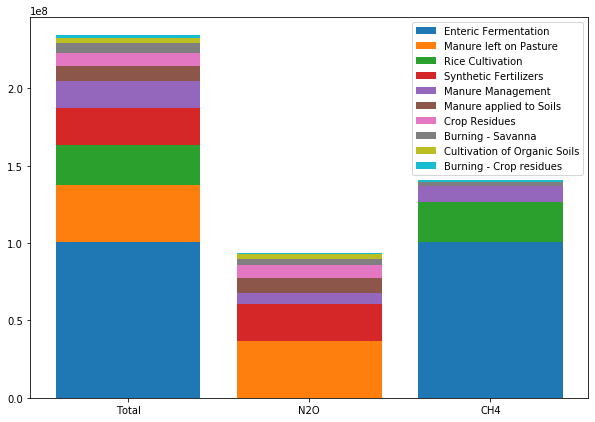

In [12]:
from matplotlib.rcsetup import cycler

fig, ax = plt.subplots(figsize=(10,7))  

items = emissions_plot['Item']
margin_bottom = np.zeros(emissions_plot.shape[1]-1)

ind = ["Total", "N2O", "CH4"]

colors = plt.cm.tab10(np.linspace(0, 1, len(emissions_plot['Item'])))

for num, item in enumerate(items):
    values = list(emissions_plot.loc[num])[1:4]
    plt.bar(ind, values, bottom=margin_bottom, color = colors[num],label=item)
    margin_bottom += values
plt.legend()
plt.show()

#should add the emissions from energy use

In total, CH4 has a bigger CO2eq impact than N20, but they are both big 

It is obvious that Enteric Fermentation is (in total) the biggest emmitor of greenhouse gasses, but this is only from CH4, and it produces no N20

We could now focus on the ones that have the most impact for example

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000BF3FA9A788>,
      dtype=object)

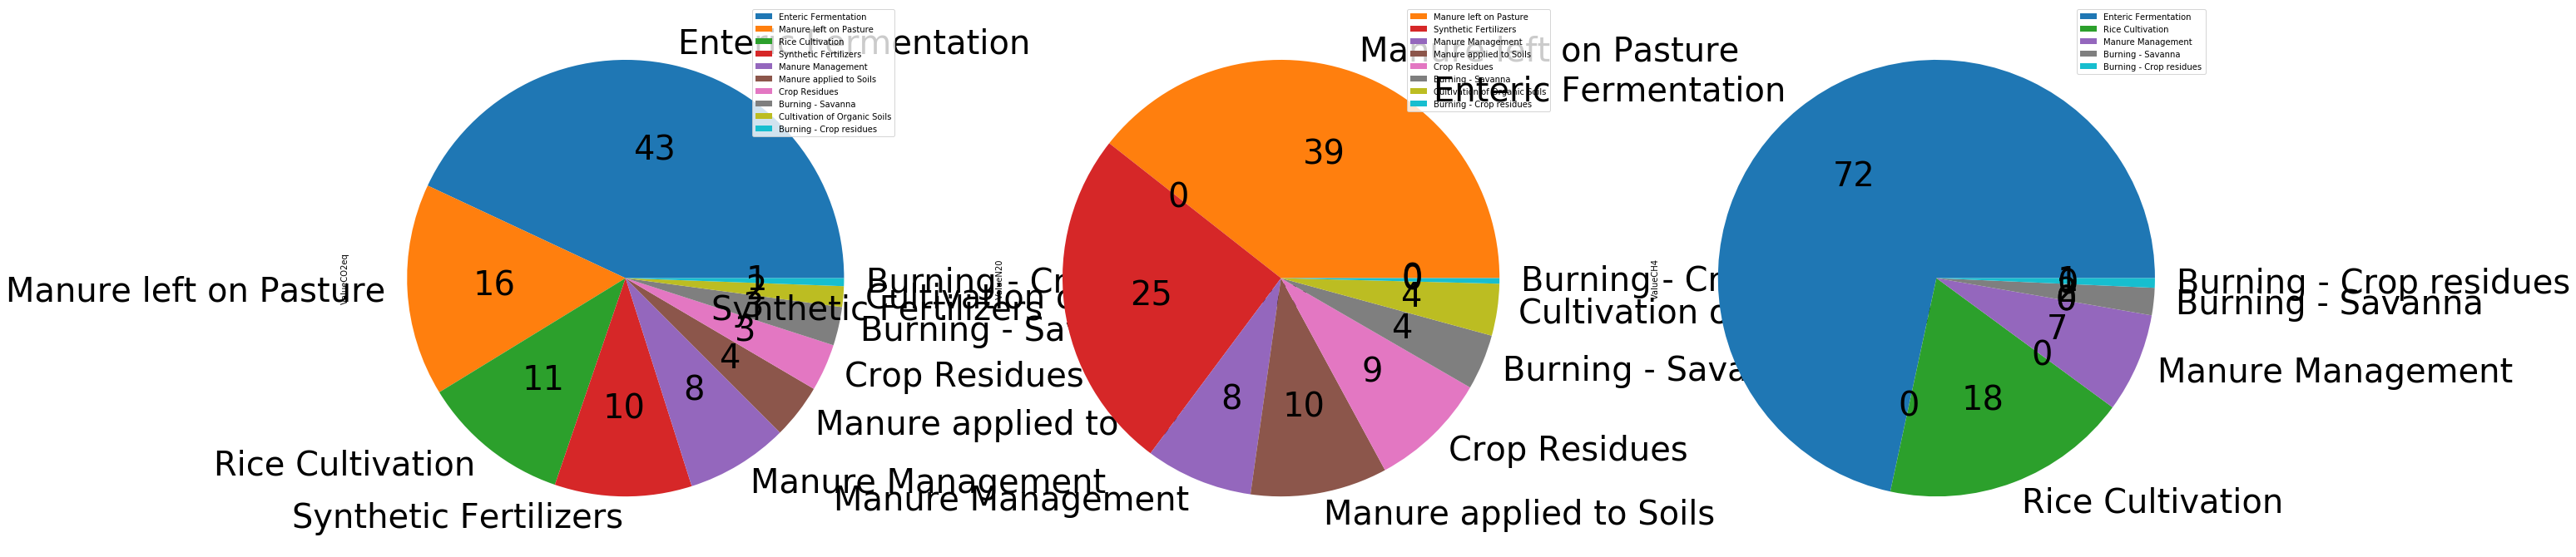

In [13]:
emissions_pieplot = emissions_world_CO2eq.join(emissions_world_N2O, lsuffix="CO2eq", rsuffix="N20").join(emissions_world_CH4)\
                    .rename({'Value':'ValueCH4'}, axis=1).fillna(0)
emissions_pieplot.plot.pie(subplots=True,figsize=(40,40), autopct='%.0f',fontsize=40)

Well this is the idea but still need to have a better legend/labels

## Transform the dataset
We transform the dataset to be able to show the evolution of the CO2eq emission by country over the years

In [14]:
# Filter only Emmisions (CO2eq)
emissions_total = emissions_total[emissions_total.Element == 'Emissions (CO2eq)']
# We can get rid of all codes + Unit + Element
emissions_total = emissions_total.drop(columns=['Country Code', 'Item Code', 'Element Code', 'Year Code', 'Unit', 'Element'])

In [15]:
# Filter only Emmisions (CO2eq)
print(emissions_total.shape)
emissions_total.head()

(139965, 5)


,Country,Item,Year,Value,Flag
0,Afghanistan,Enteric Fermentation,1961,5054.3459,A
1,Afghanistan,Enteric Fermentation,1962,5151.5228,A
2,Afghanistan,Enteric Fermentation,1963,5372.3989,A
3,Afghanistan,Enteric Fermentation,1964,5440.3650,A
4,Afghanistan,Enteric Fermentation,1965,5577.5580,A


In [16]:
# Flags
emissions_total.Flag.value_counts()

A     123645
Fc      8919
EA      7401
Name: Flag, dtype: int64

The flags represent : 
* `A` : Aggregate, may include official, semi-official, estimated or calculated data
* `Fc` : Calculated data
* `EA` : Emissions computed using data from Fertilizer Archive dataset

All these flag are acceptable we can then drop this column

In [17]:
emissions_total = emissions_total.drop(columns='Flag')

In [18]:
# Remove aggregation item
agg_item = ['Agriculture total', 'Agricultural Soils']
emissions_total = emissions_total.drop(emissions_total[emissions_total['Item'].isin(agg_item)].index)

# Remove aggregation country
emissions_total.Country.unique()
agg_country = ['World', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia & New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia', 'European Union',
       'Least Developed Countries', 'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries', 'Annex I countries',
       'Non-Annex I countries', 'OECD']
emissions_total = emissions_total.drop(emissions_total[emissions_total['Country'].isin(agg_country)].index)

In [19]:
# Pivot the table to make element columns
emissions_total = pd.pivot_table(emissions_total, values='Value', index=['Country', 'Year'], columns='Item')
emissions_total.head()

Item              Burning - Crop residues  Burning - Savanna  Crop Residues  \
Country     Year                                                              
Afghanistan 1961                 118.2797                NaN       332.7512   
            1962                 121.7607                NaN       335.2904   
            1963                 121.7607                NaN       312.7451   
            1964                 122.7093                NaN       337.2814   
            1965                 122.3902                NaN       340.9305   

Item              Cultivation of Organic Soils  Enteric Fermentation  \
Country     Year                                                       
Afghanistan 1961                           NaN             5054.3459   
            1962                           NaN             5151.5228   
            1963                           NaN             5372.3989   
            1964                           NaN             5440.3650   
            1965                           NaN             5577.5580   

Item              Manure Management  Manure applied to Soils  \
Country     Year                                               
Afghanistan 1961           367.8310                 390.4421   
            1962           376.4362                 396.0043   
            1963           392.5811                 406.7487   
            1964           399.8526                 415.1598   
            1965           413.3914                 427.7566   

Item              Manure left on Pasture  Rice Cultivation  \
Country     Year                                             
Afghanistan 1961               2368.1734             617.4   
            1962               2326.1498             617.4   
            1963               2390.2709             617.4   
            1964               2422.8848             646.8   
            1965               2482.0286             646.8   

Item              Synthetic Fertilizers  
Country     Year                         
Afghanistan 1961                 6.4546  
            1962                 6.4546  
            1963                 6.4546  
            1964                 6.4546  
            1965                 6.4546

In [20]:
# Here we assume that if there is no data the country just do not produce any emission of that type
emissions_total.fillna(0, inplace=True)

In [21]:
# Create a new column sum
emissions_total['Sum'] = emissions_total.sum(axis=1)
emissions_total.head()

Item              Burning - Crop residues  Burning - Savanna  Crop Residues  \
Country     Year                                                              
Afghanistan 1961                 118.2797                0.0       332.7512   
            1962                 121.7607                0.0       335.2904   
            1963                 121.7607                0.0       312.7451   
            1964                 122.7093                0.0       337.2814   
            1965                 122.3902                0.0       340.9305   

Item              Cultivation of Organic Soils  Enteric Fermentation  \
Country     Year                                                       
Afghanistan 1961                           0.0             5054.3459   
            1962                           0.0             5151.5228   
            1963                           0.0             5372.3989   
            1964                           0.0             5440.3650   
            1965                           0.0             5577.5580   

Item              Manure Management  Manure applied to Soils  \
Country     Year                                               
Afghanistan 1961           367.8310                 390.4421   
            1962           376.4362                 396.0043   
            1963           392.5811                 406.7487   
            1964           399.8526                 415.1598   
            1965           413.3914                 427.7566   

Item              Manure left on Pasture  Rice Cultivation  \
Country     Year                                             
Afghanistan 1961               2368.1734             617.4   
            1962               2326.1498             617.4   
            1963               2390.2709             617.4   
            1964               2422.8848             646.8   
            1965               2482.0286             646.8   

Item              Synthetic Fertilizers         Sum  
Country     Year                                     
Afghanistan 1961                 6.4546   9255.6779  
            1962                 6.4546   9331.0188  
            1963                 6.4546   9620.3600  
            1964                 6.4546   9791.5075  
            1965                 6.4546  10017.3099

In [22]:
# create a new dataframe with relative numbers
relative_emissions_total = pd.DataFrame()
for col in emissions_total.columns:
    new_col = '% '+col
    relative_emissions_total[new_col] = emissions_total[col]/emissions_total['Sum'] * 100
    
relative_emissions_total.head()

% Burning - Crop residues  % Burning - Savanna  \
Country     Year                                                   
Afghanistan 1961                   1.277915                  0.0   
            1962                   1.304903                  0.0   
            1963                   1.265656                  0.0   
            1964                   1.253222                  0.0   
            1965                   1.221787                  0.0   

                  % Crop Residues  % Cultivation of Organic Soils  \
Country     Year                                                    
Afghanistan 1961         3.595103                             0.0   
            1962         3.593288                             0.0   
            1963         3.250867                             0.0   
            1964         3.444632                             0.0   
            1965         3.403414                             0.0   

                  % Enteric Fermentation  % Manure Management  \
Country     Year                                                
Afghanistan 1961               54.608057             3.974112   
            1962               55.208578             4.034245   
            1963               55.844053             4.080732   
            1964               55.562078             4.083667   
            1965               55.679200             4.126771   

                  % Manure applied to Soils  % Manure left on Pasture  \
Country     Year                                                        
Afghanistan 1961                   4.218406                 25.586169   
            1962                   4.243956                 24.929216   
            1963                   4.227999                 24.845961   
            1964                   4.239999                 24.744758   
            1965                   4.270174                 24.777397   

                  % Rice Cultivation  % Synthetic Fertilizers  % Sum  
Country     Year                                                      
Afghanistan 1961            6.670500                 0.069737  100.0  
            1962            6.616641                 0.069174  100.0  
            1963            6.417639                 0.067093  100.0  
            1964            6.605724                 0.065920  100.0  
            1965            6.456823                 0.064434  100.0

In [23]:
# Save the datasets
emissions_total.to_csv(GENERATED_DATA_PATH+'emissions_total.csv')
relative_emissions_total.to_csv(GENERATED_DATA_PATH+'relative_emissions_total.csv')

# Emissions from energy use

In [24]:
emission_energy_path = DATA_PATH+'Emissions_Agriculture_Energy_E_All_Data_(Norm).csv'
emissions_energy = pd.read_csv(emission_energy_path, encoding='latin-1', engine='python')

In [25]:
print(emissions_energy.shape)
emissions_energy

(502743, 11)


,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1986,1986,Terajoule,288659.0000,Fc
1,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1987,1987,Terajoule,313771.0000,Fc
2,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1988,1988,Terajoule,329896.0000,Fc
3,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1989,1989,Terajoule,355094.0000,Fc
4,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1990,1990,Terajoule,379045.0000,Fc
...,...,...,...,...,...,...,...,...,...,...,...
502738,5873,OECD,6811,Energy used in fishery,723110,Emissions (CO2eq) (Energy),2008,2008,Gigagrams,16292.2033,A
502739,5873,OECD,6811,Energy used in fishery,723110,Emissions (CO2eq) (Energy),2009,2009,Gigagrams,17022.9957,A
502740,5873,OECD,6811,Energy used in fishery,723110,Emissions (CO2eq) (Energy),2010,2010,Gigagrams,17172.6343,A
502741,5873,OECD,6811,Energy used in fishery,723110,Emissions (CO2eq) (Energy),2011,2011,Gigagrams,17359.6668,A


In [26]:
print("We have the following kind of element:",emissions_energy['Element'].unique())

print("We have the following kind of item:",emissions_energy['Item'].unique())

We have the following kind of element: ['Consumption in Agriculture' 'Implied emission factor for CH4'
 'Emissions (CH4) (Energy)' 'Emissions (CO2eq) from CH4 (Energy)'
 'Implied emission factor for N2O' 'Emissions (N2O) (Energy)'
 'Emissions (CO2eq) from N2O (Energy)' 'Implied emission factor for CO2'
 'Emissions (CO2) (Energy)' 'Emissions (CO2eq) (Energy)']
We have the following kind of item: ['Gas-Diesel oil' 'Motor Gasoline' 'Natural gas (including LNG)'
 'Liquefied petroleum gas (LPG)' 'Fuel oil' 'Coal' 'Electricity'
 'Gas-diesel oils used in fisheries' 'Fuel oil used in fisheries'
 'Energy for power irrigation'
 'Transport fuel used in agriculture (excl. fishery)' 'Total Energy'
 'Energy used in fishery']


REM : the element 'Emessions (CO2eq) (Energy)' is an aggregation of the elements 'Emissions (CO2eq) from CH4 (Energy)', 'Emissions (CO2eq) from N2O (Energy)' and 'Emissions (CO2) (Energy)' 

We are only interested into the emissions in terms of CO2eq

In [27]:
# Only keep the total energy item
unint_item = ['Gas-Diesel oil', 'Motor Gasoline', 'Natural gas (including LNG)',
 'Liquefied petroleum gas (LPG)', 'Fuel oil', 'Coal', 'Electricity',
 'Gas-diesel oils used in fisheries', 'Fuel oil used in fisheries',
 'Energy for power irrigation', 'Transport fuel used in agriculture (excl. fishery)', 'Energy used in fishery']
emissions_energy = emissions_energy.drop(emissions_energy[emissions_energy['Item'].isin(unint_item)].index)



# Remove uninteresting elements
unint_elem = ['Consumption in Agriculture', 'Implied emission factor for CH4',
 'Emissions (CH4) (Energy)', 'Implied emission factor for N2O', 'Emissions (N2O) (Energy)', 
              'Implied emission factor for CO2']
emissions_energy = emissions_energy.drop(emissions_energy[emissions_energy['Element'].isin(unint_elem)].index)

# Make a new dataset with the aggregation of all emissions
emissions_energy_tot = emissions_energy[emissions_energy['Element']=='Emissions (CO2eq) (Energy)']
print(emissions_energy_tot.head())

emissions_energy

      Country Code Country  Item Code          Item  Element Code  \
3491           351   China       6813  Total Energy        723110   
3492           351   China       6813  Total Energy        723110   
3493           351   China       6813  Total Energy        723110   
3494           351   China       6813  Total Energy        723110   
3495           351   China       6813  Total Energy        723110   

                         Element  Year Code  Year       Unit   Value Flag  
3491  Emissions (CO2eq) (Energy)       1970  1970  Gigagrams  0.0000    A  
3492  Emissions (CO2eq) (Energy)       1971  1971  Gigagrams  0.0272    A  
3493  Emissions (CO2eq) (Energy)       1972  1972  Gigagrams  0.0272    A  
3494  Emissions (CO2eq) (Energy)       1973  1973  Gigagrams  0.0000    A  
3495  Emissions (CO2eq) (Energy)       1974  1974  Gigagrams  0.0000    A  


,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
3335,351,China,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1970,1970,Gigagrams,0.0000,A
3336,351,China,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1971,1971,Gigagrams,0.0252,A
3337,351,China,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1972,1972,Gigagrams,0.0252,A
3338,351,China,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1973,1973,Gigagrams,0.0000,A
3339,351,China,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1974,1974,Gigagrams,0.0000,A
...,...,...,...,...,...,...,...,...,...,...,...
502437,5873,OECD,6813,Total Energy,723110,Emissions (CO2eq) (Energy),2008,2008,Gigagrams,248957.7107,A
502438,5873,OECD,6813,Total Energy,723110,Emissions (CO2eq) (Energy),2009,2009,Gigagrams,238298.3520,A
502439,5873,OECD,6813,Total Energy,723110,Emissions (CO2eq) (Energy),2010,2010,Gigagrams,241543.2601,A
502440,5873,OECD,6813,Total Energy,723110,Emissions (CO2eq) (Energy),2011,2011,Gigagrams,236540.6103,A


In [28]:
#just looking at world total emissions from energy use in agriculture
emissions_energy_world = emissions_energy[(emissions_energy['Country'] == 'World')]
emissions_energy_world.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
390039,5000,World,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1970,1970,Gigagrams,2283.8021,A
390040,5000,World,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1971,1971,Gigagrams,2510.2211,A
390041,5000,World,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1972,1972,Gigagrams,2735.9649,A
390042,5000,World,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1973,1973,Gigagrams,3046.6713,A
390043,5000,World,6813,Total Energy,724410,Emissions (CO2eq) from CH4 (Energy),1974,1974,Gigagrams,3325.0557,A


In [29]:
emissions_energy_world_CO2eq = emissions_energy_world[emissions_energy_world['Element'] == 'Emissions (CO2eq) (Energy)']
emissions_energy_world_CO2eq = emissions_energy_world_CO2eq[columns].groupby(['Item']).sum().reset_index().set_index('Item')
print(emissions_energy_world_CO2eq)
emissions_world_CO2eq = emissions_world_CO2eq.append(emissions_energy_world_CO2eq)
emissions_world_CO2eq.sort_values('Value', ascending=False, inplace=True)
emissions_world_CO2eq.head(20)

                     Value
Item                      
Total Energy  2.280035e+07


,Value
Item,
Enteric Fermentation,1.007673e+08
Manure left on Pasture,3.681827e+07
Rice Cultivation,2.576103e+07
Synthetic Fertilizers,2.375089e+07
Total Energy,2.280035e+07
Manure Management,1.777713e+07
Manure applied to Soils,9.465197e+06
Crop Residues,8.178448e+06
Burning - Savanna,6.683734e+06


Let's do the same for CH4, NO2 and CO2

In [30]:
emissions_energy_world_N2O = emissions_energy_world[emissions_energy_world['Element'] == 'Emissions (CO2eq) from N2O (Energy)']
emissions_energy_world_N2O = emissions_energy_world_N2O[columns].groupby(['Item']).sum().reset_index().set_index('Item')
print(emissions_energy_world_N2O)
emissions_world_N2O = emissions_world_N2O.append(emissions_energy_world_N2O)
emissions_world_N2O.sort_values('Value', ascending=False, inplace=True)
emissions_world_N2O.head(20)

                     Value
Item                      
Total Energy  1.172867e+06


,Value
Item,
Manure left on Pasture,3.681827e+07
Synthetic Fertilizers,2.375089e+07
Manure applied to Soils,9.465197e+06
Crop Residues,8.178448e+06
Manure Management,7.436514e+06
Burning - Savanna,3.836958e+06
Cultivation of Organic Soils,3.585999e+06
Total Energy,1.172867e+06
Burning - Crop residues,3.807684e+05


In [31]:
emissions_energy_world_CH4 = emissions_energy_world[emissions_energy_world['Element'] == 'Emissions (CO2eq) from CH4 (Energy)']
emissions_energy_world_CH4 = emissions_energy_world_CH4[columns].groupby(['Item']).sum().reset_index().set_index('Item')
print(emissions_energy_world_CH4)
emissions_world_CH4 = emissions_world_CH4.append(emissions_energy_world_CH4)
emissions_world_CH4.sort_values('Value', ascending=False, inplace=True)
emissions_world_CH4.head(20)

                    Value
Item                     
Total Energy  581625.1828


,Value
Item,
Enteric Fermentation,1.007673e+08
Rice Cultivation,2.576103e+07
Manure Management,1.034062e+07
Burning - Savanna,2.846776e+06
Burning - Crop residues,9.949110e+05
Total Energy,5.816252e+05


In [32]:
#for CO2, we can directly create a new dataframe because there is no CO2 emissions in agriculture out of energy use
emissions_world_CO2 = emissions_energy_world[emissions_energy_world['Element'] == 'Emissions (CO2) (Energy)']
emissions_world_CO2 = emissions_world_CO2[columns].groupby(['Item']).sum().reset_index().set_index('Item')
print(emissions_world_CO2)

                     Value
Item                      
Total Energy  2.104586e+07


Now we can do again the plots but with the energy emissions included

In [42]:
# Left join
emissions_plot = emissions_world_CO2eq.join(emissions_world_N2O, lsuffix="CO2eq", rsuffix="N20").join(emissions_world_CH4)\
                    .rename({'Value':'ValueCH4'}, axis=1).fillna(0)
emissions_plot = emissions_plot.join(emissions_world_CO2).rename({'Value':'ValueCO2'},axis=1).reset_index().fillna(0)
emissions_plot.head(10)

,Item,ValueCO2eq,ValueN20,ValueCH4,ValueCO2
0,Enteric Fermentation,1.007673e+08,0.000000e+00,1.007673e+08,0.000000e+00
1,Manure left on Pasture,3.681827e+07,3.681827e+07,0.000000e+00,0.000000e+00
2,Rice Cultivation,2.576103e+07,0.000000e+00,2.576103e+07,0.000000e+00
3,Synthetic Fertilizers,2.375089e+07,2.375089e+07,0.000000e+00,0.000000e+00
4,Total Energy,2.280035e+07,1.172867e+06,5.816252e+05,2.104586e+07
5,Manure Management,1.777713e+07,7.436514e+06,1.034062e+07,0.000000e+00
6,Manure applied to Soils,9.465197e+06,9.465197e+06,0.000000e+00,0.000000e+00
7,Crop Residues,8.178448e+06,8.178448e+06,0.000000e+00,0.000000e+00
8,Burning - Savanna,6.683734e+06,3.836958e+06,2.846776e+06,0.000000e+00
9,Cultivation of Organic Soils,3.585999e+06,3.585999e+06,0.000000e+00,0.000000e+00


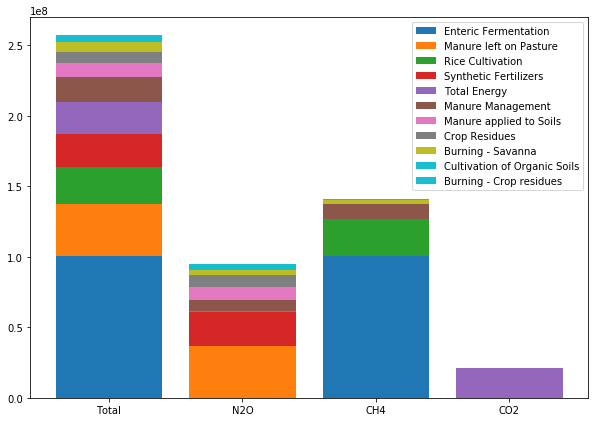

In [43]:
fig, ax = plt.subplots(figsize=(10,7))  

items = emissions_plot['Item']
margin_bottom = np.zeros(emissions_plot.shape[1]-1)

ind = ["Total", "N2O", "CH4", "CO2"]

colors = plt.cm.tab10(np.linspace(0, 1, len(emissions_plot['Item'])))

for num, item in enumerate(items):
    values = list(emissions_plot.loc[num])[1:5]
    plt.bar(ind, values, bottom=margin_bottom, color = colors[num],label=item)
    margin_bottom += values
plt.legend()
plt.show()

We get the same graphs with the energy emissions added which are not negligible.